In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

## following back

In [2]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

## new features

In [3]:
train_graph=nx.read_edgelist('train_clean.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

def new_features(df):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

## featurization

In [4]:
df_train = pd.read_csv("train_graph_features.csv")
df_test = pd.read_csv("test_graph_features.csv")
df_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,shortest_path_length,belongs_to_same_wcc,adar_index,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,681210,578094,1.0,0,0.066667,0,0,2,1,1.047952,1.581296e-06,2.363783e-07,0.000761,0.000739,1.315252e-17,1.997768e-19,2.633042e-17,1.168928e-19
1,1015263,1228626,1.0,0,0.000000,0,0,3,1,0.000000,3.246765e-07,1.829068e-06,0.000735,0.000777,4.885614e-18,1.850402e-18,2.272397e-23,6.804640e-16
2,1259643,1022345,1.0,0,0.333333,0,0,2,1,2.940405,3.734641e-07,3.866163e-07,0.000751,0.000747,6.613329e-18,1.160654e-17,6.812246e-19,4.747461e-18
3,1570194,1742232,1.0,0,0.300000,0,0,2,1,3.763725,1.406635e-06,3.724099e-07,0.000757,0.000743,1.190506e-16,2.352525e-18,7.643179e-16,1.528837e-18
4,637374,1344,1.0,0,0.000000,0,0,5,1,0.000000,1.655650e-07,1.373647e-06,0.000731,0.000768,1.051982e-14,0.000000e+00,0.000000e+00,1.282472e-15


In [5]:
df_train['follows_back'] = df_train.apply(lambda row:
                                            follows_back(row['source_node'],row['destination_node']),axis=1)
df_test['follows_back'] = df_test.apply(lambda row:
                                            follows_back(row['source_node'],row['destination_node']),axis=1)

In [7]:
df_train['num_followers_s'], df_train['num_followers_d'], \
df_train['num_followees_s'], df_train['num_followees_d'], \
df_train['inter_followers'], df_train['inter_followees'] = new_features(df_train)
    
df_test['num_followers_s'], df_test['num_followers_d'], \
df_test['num_followees_s'], df_test['num_followees_d'], \
df_test['inter_followers'], df_test['inter_followees'] = new_features(df_test)

## classification models on graph based features and non-graph based features

In [9]:
y_train = df_train.indicator_link
y_test = df_test.indicator_link

In [10]:
df_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [11]:
x_train = df_train.values
x_test = df_test.values

y_train = y_train.values
y_test = y_test.values

y_train.reshape(-1,1)
y_test.reshape(-1,1)

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [12]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

In [13]:
estimators = [10, 50, 100, 250, 500, 1000, 2000]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(x_train,y_train)
    train_sc = f1_score(y_train,clf.predict(x_train))
    test_sc = f1_score(y_test,clf.predict(x_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)

Estimators =  10 Train Score 0.9337290641943975 test Score 0.9339731851571215
Estimators =  50 Train Score 0.9431310440309622 test Score 0.9426260583849362
Estimators =  100 Train Score 0.9413326030629227 test Score 0.941201362588071
Estimators =  250 Train Score 0.9420235017132287 test Score 0.9418074324324325
Estimators =  500 Train Score 0.9424237652863066 test Score 0.9420518982271969
Estimators =  1000 Train Score 0.9424768542816955 test Score 0.9421337774311191
Estimators =  2000 Train Score 0.942379787245214 test Score 0.9420595428860588


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

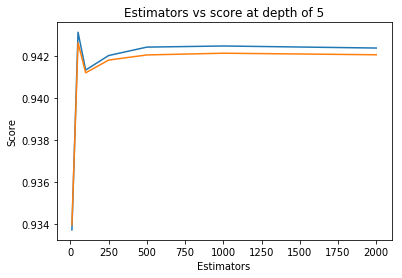

In [14]:
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

In [15]:
max_depth = [5, 7, 9, 11, 12, 13, 15]
train_scores = []
test_scores = []
for i in max_depth:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth = i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators = 500, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(x_train,y_train)
    train_sc = f1_score(y_train,clf.predict(x_train))
    test_sc = f1_score(y_test,clf.predict(x_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('max_depth = ',i,'Train Score',train_sc,'test Score',test_sc)

max_depth =  5 Train Score 0.9424237652863066 test Score 0.9420518982271969
max_depth =  7 Train Score 0.9457674730619261 test Score 0.9456757382500894
max_depth =  9 Train Score 0.9486275207467794 test Score 0.9489189132398983
max_depth =  11 Train Score 0.9505111961362354 test Score 0.9508141682054725
max_depth =  12 Train Score 0.9519964109466127 test Score 0.952287198391421
max_depth =  13 Train Score 0.9523412156171442 test Score 0.95261030720583
max_depth =  15 Train Score 0.9519893124034567 test Score 0.9519758622134685


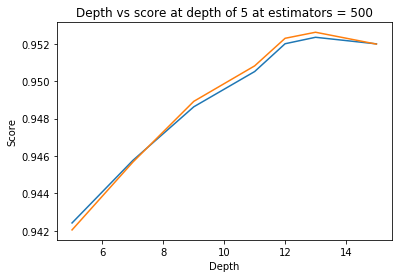

In [16]:
plt.plot(max_depth,train_scores,label='Train Score')
plt.plot(max_depth,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 500')
plt.show()

In [17]:
from sklearn.model_selection import RandomizedSearchCV

In [18]:
grid = {'n_estimators': estimators, 'max_depth': max_depth}

In [19]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)

In [20]:
rf = RandomizedSearchCV(estimator = clf, param_distributions = grid, n_iter = 100, cv = 3, verbose=0, n_jobs = -1)

In [21]:
rf.fit(x_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [10, 50, 100, 250, 500, 1000, 2000], 'max_depth': [5, 7, 9, 11, 12, 13, 15]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [22]:
train_sc = f1_score(y_train,rf.predict(x_train))
test_sc = f1_score(y_test,rf.predict(x_test))

In [23]:
train_sc

0.9526241488124896

In [24]:
test_sc

0.9530855963819012